# Movement detection by cross correlation of points

The basic idea is that we could buffer the detected normalized unrotated (DNU) points, henceforth called DNUV (V for video). If we compare, after each frame, the DNUV with the DNUV reference using the normalized cross reference, we would get, in case of a match, a value that is between 0 and 1 and close to one. Do that for every DNUV reference and we basically return to the same approach of the static gestures, where the match is the one that has greather value. 

We would have to consider that each point has its own 3D signal, run the cross reference evaluation in each of the signal and average all the cross references.

The point of using cross reference is that it is invariant to time shifts, which should be the only valid difference of a matched DNUV reference and an incoming DNUV.

The plan for this Jupyter Notebook is to first test if this is a valid idea, with simple 1D functions in time. Afterwards, in case of success in this simple case, we'll delve into exploring 2D and 3D functions in time (should produce some pretty videos). Then the idea is to try using a poorly sampled function with interpolation to account for fails in sensing. If that goes nice, a final test will be done using the full hand signals from mediapipe.

## 1D Function matching using cross correlation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from scipy import interpolate
import mediapipe as mp
from datetime import datetime
import cv2
import time
from gesture.base import Gesture, to_hand_frame
import pandas as pd

Let's generate two simple functions that are equal and calculate the average cross correlation. First we'll implement a function that calculates the average cross correlation given two signals.

In [2]:
def mncc(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Maximum normalized cross-correlation (MNCC) between two signals.

    Parameters
    ----------
    a : np.ndarray
        First signal.
    b : np.ndarray
        Second signal.
    
    Returns
    -------
    np.ndarray
        Maximum normalized cross-correlation between the two signals.
    """
    a = a - np.mean(a)
    b = b - np.mean(b)
    ncc = np.correlate(a, b, mode='full') / (np.linalg.norm(a) * np.linalg.norm(b))
    return ncc.max()

In [73]:
def incc(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Integrated normalized cross-correlation (INCC) between two signals.

    Parameters
    ----------
    a : np.ndarray
        First signal.
    b : np.ndarray
        Second signal.
    
    Returns
    -------
    np.ndarray
        Integrated normalized cross-correlation between the two signals.
    """
    a = a - np.mean(a)
    b = b - np.mean(b)
    if np.linalg.norm(a) == 0 or np.linalg.norm(b) == 0:
        ncc = np.correlate(a, b, mode='full')
        ncca = np.correlate(a, a, mode='full')
        nccb = np.correlate(b, b, mode='full')
    else:
        ncc = np.correlate(a, b, mode='full') / (np.linalg.norm(a) * np.linalg.norm(b))
        ncca = np.correlate(a, a, mode='full') / (np.linalg.norm(a) * np.linalg.norm(a))
        nccb = np.correlate(b, b, mode='full') / (np.linalg.norm(b) * np.linalg.norm(b))
    incc = np.trapz(np.abs(ncc))
    # incc isn't between 0 and 1, so we normalize it by the incc of a with itself
    incca = np.trapz(np.abs(ncca))
    inccb = np.trapz(np.abs(nccb))
    inccd = np.max([incca, inccb])
    if inccd == 0:
        return incc
    else:
        return incc / inccd

Now testing with two exactly equal signals

INCC(a, a) = 1.0


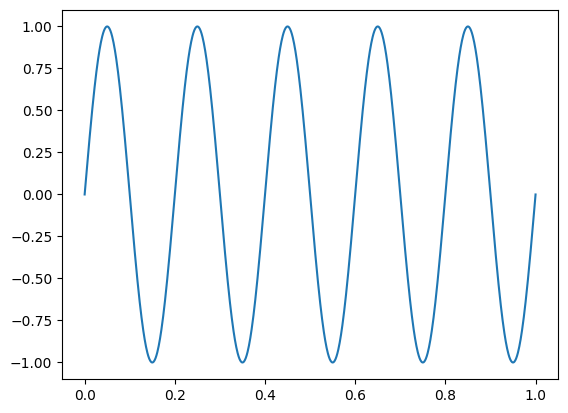

In [74]:
t = np.linspace(0, 1, 1000)
a = np.sin(2 * np.pi * 5 * t)
plt.plot(t, a)
ncc = incc(a, a)
print(f'INCC(a, a) = {ncc}')

And using noise

INCC(a, a_noise) = 0.9899078602476897
MNCC(a, a_noise) = 0.9901068557053766


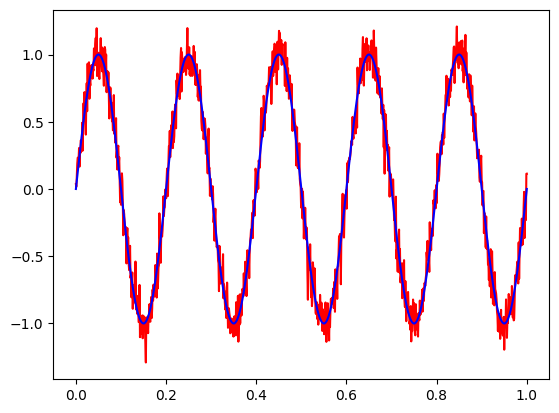

In [75]:
noise_level = .1
a_noise = a + noise_level * np.random.randn(a.shape[0])
plt.plot(t, a_noise, color='red')
plt.plot(t, a, color='blue')
ncc = incc(a, a_noise)
print(f'INCC(a, a_noise) = {ncc}')
print(f'MNCC(a, a_noise) = {mncc(a, a_noise)}')

Which shows that even with high noise_levels (play around with it) we get a very decent value that is possible to use in signal matching.

Let's try with translations!

First a function to ease shifts

In [76]:
def shift_signal(
    t: np.ndarray, a: np.ndarray, shift: float
) -> tuple[np.ndarray, np.ndarray]:
    """
    Shifts a signal (to the right) by a given amount.

    Parameters
    ----------
    t : np.ndarray
        Time points of the signal.
    a : np.ndarray
        Signal to shift.
    shift : float
        Amount (of time) to shift the signal by.

    Returns
    -------
    t_shifted: np.ndarray
        Shifted time points.
    a_shifted: np.ndarray
        Shifted signal.
    """
    t_shifted = np.concatenate((np.arange(-shift, 0, t[1] - t[0]), t), axis=0)
    a_shifted = np.concatenate((np.zeros(t_shifted.shape[0] - t.shape[0]), a), axis=0)
    return t_shifted, a_shifted

def shift_signal_left(
    t: np.ndarray, a: np.ndarray, shift: float
) -> tuple[np.ndarray, np.ndarray]:
    """
    Shifts a signal (to the left) by a given amount.

    Parameters
    ----------
    t : np.ndarray
        Time points of the signal.
    a : np.ndarray
        Signal to shift.
    shift : float
        Amount (of time) to shift the signal by.

    Returns
    -------
    t_shifted: np.ndarray
        Shifted time points.
    a_shifted: np.ndarray
        Shifted signal.
    """
    t_shifted = np.concatenate((t, np.arange(t[-1] + t[1] - t[0], t[-1] + shift, t[1] - t[0])), axis=0)
    a_shifted = np.concatenate((a, np.zeros(t_shifted.shape[0] - t.shape[0])), axis=0)
    return t_shifted, a_shifted

Now testing with right and left shifts

INCC(a, a_shifted) = 1.0
MNCC(a, a_shifted) = 1.0


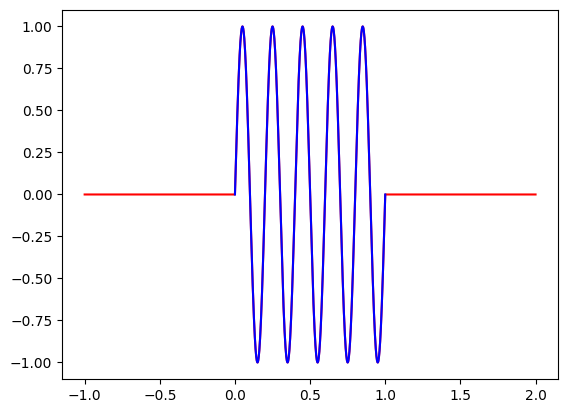

In [77]:
shift = 1
t_shifted, a_shifted = shift_signal(t, a, shift)
t_shifted, a_shifted = shift_signal_left(t_shifted, a_shifted, shift)
plt.plot(t_shifted, a_shifted, color='red')
plt.plot(t, a, color='blue')
print(f'INCC(a, a_shifted) = {incc(a, a_shifted)}')
print(f'MNCC(a, a_shifted) = {mncc(a, a_shifted)}')

And with noisy shifts

MNCC(a, a_shifted) = 0.9707223120691523
INCC(a, a_shifted) = 0.977471524479092


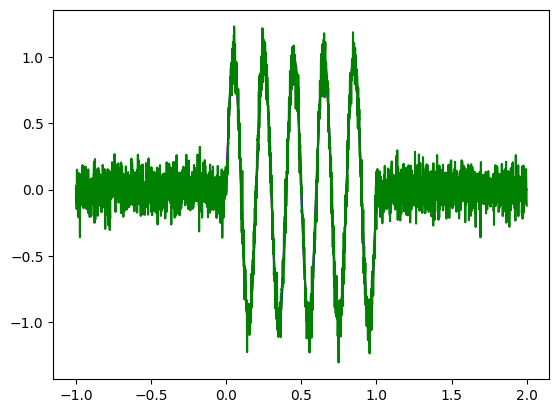

In [78]:
noise_level = .1
a_shifted_noise = a_shifted + noise_level * np.random.randn(a_shifted.shape[0])
plt.plot(t_shifted, a_shifted, color='red')
plt.plot(t, a, color='blue')
plt.plot(t_shifted, a_shifted_noise, color='green')
print(f'MNCC(a, a_shifted) = {mncc(a, a_shifted_noise)}')
print(f'INCC(a, a_shifted) = {incc(a, a_shifted_noise)}')

Even with noisy shifts the MNCC indicator is a good matching index!

Although it suffers more with noise when the shifts are larger, this is due to the fact that in that case, the gross amount of the signal's energy is in noise. Hopefully our signals aren't that noisy, if they are, we can always filter. 

### Can we match 1D signals that have complex shapes?

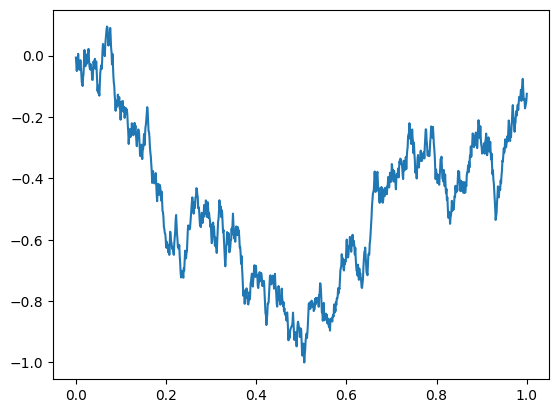

In [79]:
seed = np.random.rand(1000) - .5
signal_base = np.cumsum(seed)
signal_base /= np.max(np.abs(signal_base)) # Normalize
t = np.linspace(0, 1, 1000)
plt.plot(t, signal_base)

Let's calculate the similarity with a shifted version of it.

MNCC(signal_base, signal_sifted) = 0.5453723284748007
INCC(signal_base, signal_sifted) = 0.3082196103084898
INCC(signal_siifted, signal_base) = 0.30821961030848977
INCC(signal_base, signal_base) = 1.0


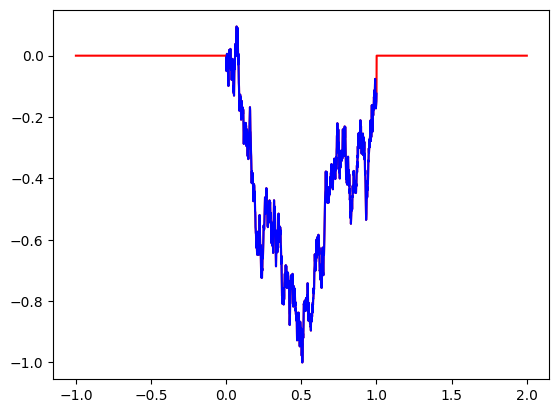

In [80]:
t_shifted, signal_sifted = shift_signal(t, signal_base, 1)
t_shifted, signal_sifted = shift_signal_left(t_shifted, signal_sifted, 1)
plt.plot(t_shifted, signal_sifted, color='red')
plt.plot(t, signal_base, color='blue')
print(f'MNCC(signal_base, signal_sifted) = {mncc(signal_base, signal_sifted)}')
print(f'INCC(signal_base, signal_sifted) = {incc(signal_base, signal_sifted)}')
print(f'INCC(signal_siifted, signal_base) = {incc(signal_sifted, signal_base)}')
print(f'INCC(signal_base, signal_base) = {incc(signal_base, signal_base)}')

Which the same effectiveness. Let's try a vertical shift!

MNCC(signal_base, signal_sifted) = 0.5453723284748007
INCC(signal_base, signal_sifted) = 0.3082196103084898


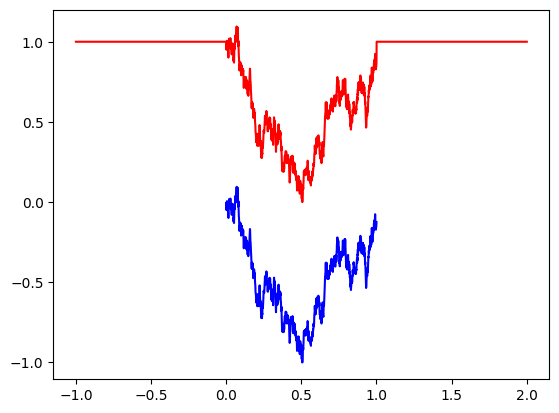

In [81]:
signal_sifted += 1
plt.plot(t_shifted, signal_sifted, color='red')
plt.plot(t, signal_base, color='blue')
print(f'MNCC(signal_base, signal_sifted) = {mncc(signal_base, signal_sifted)}')
print(f'INCC(signal_base, signal_sifted) = {incc(signal_base, signal_sifted)}')

Which is exactly the same MNCC!

With noise...

MNCC(signal_base, signal_sifted) = 0.5183786449634565
INCC(signal_base, signal_sifted) = 0.32984663862725044


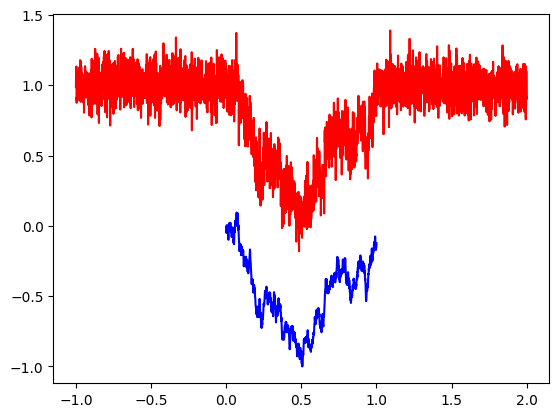

In [82]:
noise_level = .1
signal_sifted += noise_level * np.random.randn(signal_sifted.shape[0])
plt.plot(t_shifted, signal_sifted, color='red')
plt.plot(t, signal_base, color='blue')
print(f'MNCC(signal_base, signal_sifted) = {mncc(signal_base, signal_sifted)}')
print(f'INCC(signal_base, signal_sifted) = {incc(signal_base, signal_sifted)}')

Which works just as fine as before.

## Matching 2D lines 

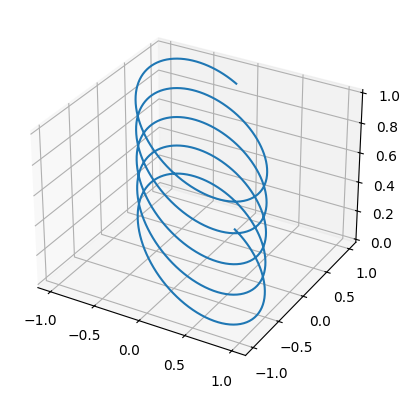

In [83]:
t = np.linspace(0, 1, 1000)
x = np.sin(2 * np.pi * 5 * t) # Signal x coordinate
y = np.cos(2 * np.pi * 5 * t + np.pi / 4) # Signal y coordinate
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.plot(x, y, t)

Comparing with a shifted version of it

Mean MNCC = 0.9999997727478803
Mean INCC = 0.9999975522013421


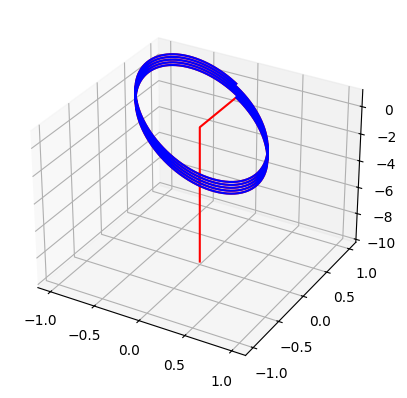

In [84]:
t_shifted, x_shifted = shift_signal(t, x, 10)
t_shifted, y_shifted = shift_signal(t, y, 10)
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.plot(x_shifted, y_shifted, t_shifted, color='red')
ax.plot(x, y, t, color='blue')
mean_mncc = (mncc(x, x_shifted) + mncc(y, y_shifted)) / 2
print(f'Mean MNCC = {mean_mncc}')
mean_incc = (incc(x, x_shifted) + incc(y, y_shifted)) / 2
print(f'Mean INCC = {mean_incc}')

Which works just as fine in 2D as in 1D. Let's try with other shifts.

Mean MNCC = 0.9999997727478802
Mean INCC = 0.999997552201342


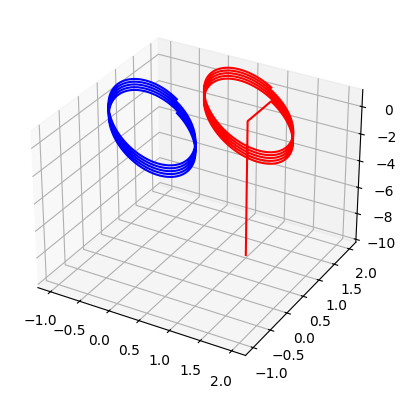

In [85]:
x_shifted += 1
y_shifted += 1
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.plot(x_shifted, y_shifted, t_shifted, color='red')
ax.plot(x, y, t, color='blue')
mean_mncc = (mncc(x, x_shifted) + mncc(y, y_shifted)) / 2
print(f'Mean MNCC = {mean_mncc}')
mean_incc = (incc(x, x_shifted) + incc(y, y_shifted)) / 2
print(f'Mean INCC = {mean_incc}')

Works amazingly well. Noise?

Mean MNCC = 0.9739348564139161
Mean INCC = 0.9995321256948375


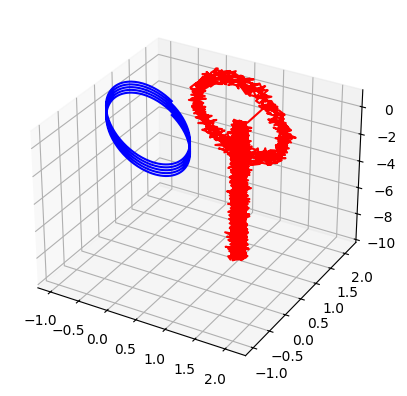

In [86]:
noise_level = .05
x_shifted += noise_level * np.random.randn(x_shifted.shape[0])
y_shifted += noise_level * np.random.randn(y_shifted.shape[0])
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.plot(x_shifted, y_shifted, t_shifted, color='red')
ax.plot(x, y, t, color='blue')
mean_mncc = (mncc(x, x_shifted) + mncc(y, y_shifted)) / 2
print(f'Mean MNCC = {mean_mncc}')
mean_incc = (incc(x, x_shifted) + incc(y, y_shifted)) / 2
print(f'Mean INCC = {mean_incc}')

Kinda impressive...

What about two different signals? What's the Mean MNCC?

Mean MNCC = 0.11876081850385237
Mean INCC = 0.18253548087659555


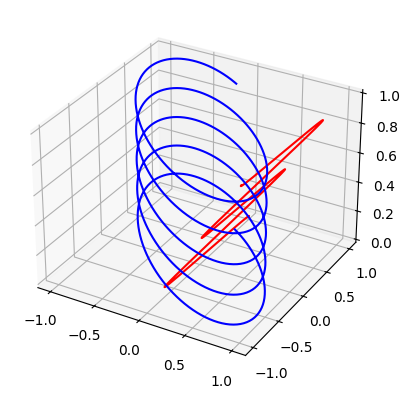

In [87]:
x_d = t * 1
y_d = np.cos(1 * np.pi * 5 * t) # Signal y coordinate
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.plot(x_d, y_d, t, color='red')
ax.plot(x, y, t, color='blue')
mean_mncc = (mncc(x, x_d) + mncc(y, y_d)) / 2
print(f'Mean MNCC = {mean_mncc}')
mean_incc = (incc(x, x_d) + incc(y, y_d)) / 2
print(f'Mean INCC = {mean_incc}')

Fairly different shapes do indeed have different MMNCC. Amazing!!!!

## 3D Lines

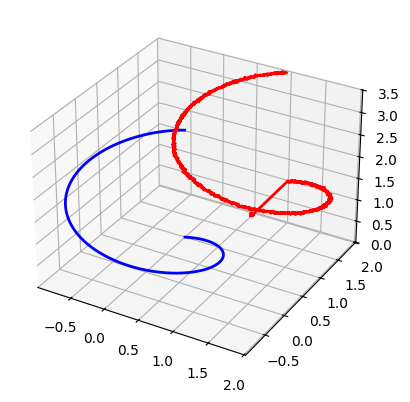

In [88]:
t = np.linspace(0, 1, 1000)
x = np.sin(2 * np.pi * t )  # Signal x coordinate
y = np.cos(2 * np.pi * t)  # Signal y coordinate
z = t/2 + t*2 # Signal z coordinate

noise_level = .01
t_shifted, x_shifted = shift_signal(t, x, .1)
t_shifted, y_shifted = shift_signal(t, y, .1)
t_shifted, z_shifted = shift_signal(t, z, .1)
x_shifted += 1
y_shifted += 1
z_shifted += 1
x_shifted += noise_level * np.random.randn(x_shifted.shape[0])
y_shifted += noise_level * np.random.randn(y_shifted.shape[0])
z_shifted += noise_level * np.random.randn(z_shifted.shape[0])
# t_shifted = np.concatenate((np.arange()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# ax.view_init(-90, 90, 0)
base_shape_plt = ax.plot([], [], [], "b", lw=2)[0]
shifted_shape_plt = ax.plot([], [], [], "r", lw=2)[0]

def init():
    x_min = min(x.min(), x_shifted.min())
    x_max = max(x.max(), x_shifted.max())
    y_min = min(y.min(), y_shifted.min())
    y_max = max(y.max(), y_shifted.max())
    z_min = min(z.min(), z_shifted.min())
    z_max = max(z.max(), z_shifted.max())
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    return base_shape_plt, shifted_shape_plt


def update(i):
    base_shape_plt.set_data_3d(np.array([x[:i], y[:i], z[:i]]))
    shifted_shape_plt.set_data_3d(np.array([x_shifted[:i], y_shifted[:i], z_shifted[:i]]))
    return base_shape_plt, shifted_shape_plt


ani = FuncAnimation(fig=fig, func=update, init_func=init, frames=[i for i in range(0, t_shifted.shape[0], 10)], blit=True, interval=10)

HTML(ani.to_html5_video())

In [89]:
mean_mncc = (mncc(x, x_shifted) + mncc(y, y_shifted) + mncc(z, z_shifted)) / 3
print(f'Mean MNCC = {mean_mncc}')
mean_incc = (incc(x, x_shifted) + incc(y, y_shifted) + incc(z, z_shifted)) / 3
print(f'Mean INCC = {mean_incc}')

Mean MNCC = 0.9620985165420787
Mean INCC = 0.9817959937928307


Which also works great!

## Bad Sampling

How to do this?

Assumption:

1. The time of each sample is known;
2. The base shape is evenly sampled in time, even if artificially.

Assuming that the time vector $t_b$ is the evenly sampled base time vector. With this we can take the interval
$$
I=t_{b_2}-t_{b_1}
$$,
and create the time vector for the test shape $t_{tr}$ from the unevenly sampled time vector $t_t$ as

$$
t_{tr} = iI\ \forall{i}\ \in\ [0,1,\cdots,n_t]
$$,
where $n_t$ is given by
$$
n_t = \textit{ceil}\left(\frac{t[-1]-t[0]}{I}\right)
$$

Since 1D, 2D and 3D work the same, we'll stick to 1D examples as they're easier to implement

MNCC(x_b, x_t_shifted) = 0.1713102310563466
INCC(x_b, x_t) = 0.1530200909609546


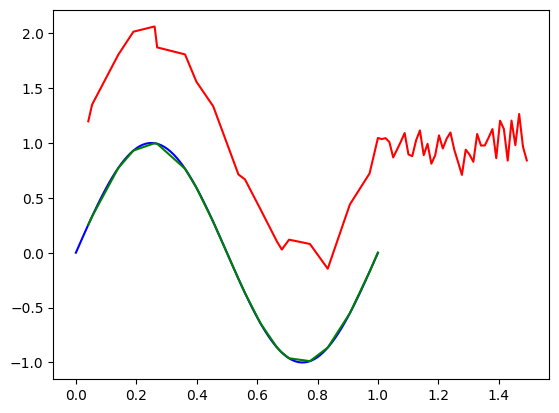

In [90]:
# Simple base signal
t_b = np.linspace(0, 1, 100)
x_b = np.sin(2 * np.pi * t_b)  # Signal x coordinate

# Creating the shifted, noisy, translated, badly sampled signal.
seed = np.cumsum(np.random.rand(20))
t_t = seed / seed[-1] * 1
x_t = np.sin(2 * np.pi * t_t)  # Same generating function as the base signal, sampled in different time points.
t_t_shifted, x_t_shifted = shift_signal(t_t, x_t, 0)  # Shifted signal
t_t_shifted, x_t_shifted = shift_signal_left(t_t_shifted, x_t_shifted, .5)  # Shifted signal
x_t_shifted += 1  # Translated signal
x_t_shifted += .1 * np.random.randn(x_t_shifted.shape[0])  # Noisy signal

# Let's plot the signals to see how they look like.
plt.plot(t_b, x_b, color='blue')
plt.plot(t_t, x_t, color='green')
plt.plot(t_t_shifted, x_t_shifted, color='red')

# MNCC doesn't work here due to the bad sampling
val = mncc(x_b, x_t_shifted)
print(f'MNCC(x_b, x_t_shifted) = {val}')

# To show this is the we can calculate the MNCC between the blue and green signals,
# which differ only in the time points they were sampled.
val = incc(x_b, x_t)
print(f'INCC(x_b, x_t) = {val}')


The above cell not only creates the signals but shows the ineffectiveness of the proposed approach when the time samples are not correctly dwelt with 

In [91]:
def interpolate_match(t_b, t_t, x_t):
    """
    Interpolates the signal x_t to match the time points of x_b.

    Parameters
    ----------
    t_b : np.ndarray
        Time points of the base signal.
    t_t : np.ndarray
        Time points of the target signal.
    x_t : np.ndarray
        Target signal.

    Returns
    -------
    t_tr : np.ndarray
        Time points of the interpolated signal.
    x_tr : np.ndarray
        Interpolated signal.
    """
    I = t_b[1] - t_b[0]
    nt = np.ceil((t_t[-1] - t_t[0]) / I) + 1
    t_tr = np.linspace(t_t[0], t_t[-1], int(nt))
    x_tr = interpolate.interp1d(t_t, x_t, kind='cubic')(t_tr)
    return t_tr, x_tr

INCC(x_b, x_tr) = 0.9921557196730425


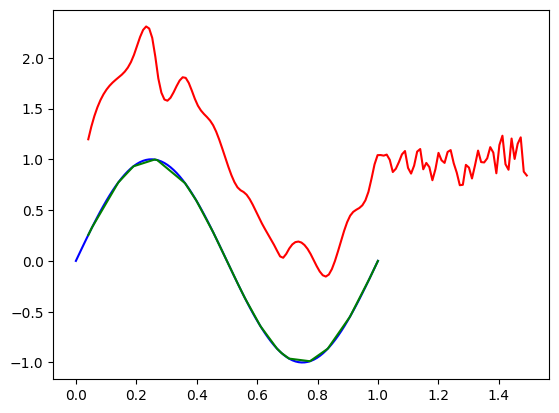

In [92]:

# I = t_b[1] - t_b[0]
# nt = np.ceil((t_t_shifted[-1] - t_t_shifted[0])/ I)
# t_tr = np.linspace(t_t_shifted[0], t_t_shifted[-1], int(nt))
# x_tr = interpolate.interp1d(t_t_shifted, x_t_shifted, kind='cubic')(t_tr)
t_tr, x_tr = interpolate_match(t_b, t_t_shifted, x_t_shifted)

# Let's plot the signals to see how they look like.
plt.plot(t_b, x_b, color='blue')
plt.plot(t_t, x_t, color='green')
plt.plot(t_tr, x_tr, color='red')

val = incc(x_b, x_tr)
print(f'INCC(x_b, x_tr) = {val}')

Effectively solving the problem

There's still one test!

What if the incoming shape is composed of the base gesture PLUS something else meaningful?

The current implementation experimented here would probably give the bigger error for the smallest similar movement. To illustrate, assume that the gesture for 1 is a movement, then the 11 gesture would not be identified, since the smaller 1 movement gesture would yield a higher correlation. This happens because the maximum correlation is used, what are other options?

I think that the Integrated Normalized cross-correlation should fix that. Let's test!

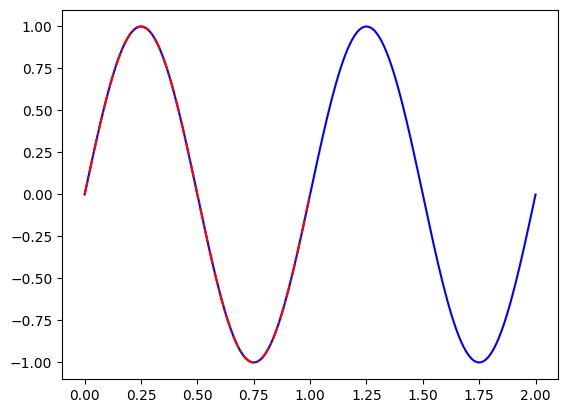

In [93]:
t_bc = np.linspace(0, 2, 200)
x_bc = np.sin(2 * np.pi * t_bc)  # Signal x coordinate
# And some less complex signal
t_b = np.linspace(0, 1, 100)
x_b = np.sin(2 * np.pi * t_b)  # Signal x coordinate
plt.plot(t_bc, x_bc, color='blue')
plt.plot(t_b, x_b, color='red', linestyle='-.')

This could be one example, both red and blue shapes are valid. Blue is composed by two red movements.

INCC(x_bcn, x_bc) = 0.991567025013354
INCC(x_bn, x_bc) = 0.7128407434291707
INCC(x_bn, x_b = 0.9985446705231659
INCC(x_bcn, x_b = 0.7246365391826778


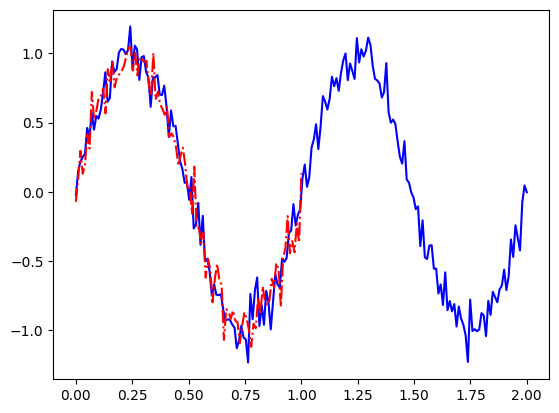

In [94]:
x_bcn = x_bc + .1 * np.random.randn(x_bc.shape[0])
x_bn = x_b + .1 * np.random.randn(x_b.shape[0])
plt.plot(t_bc, x_bcn, color='blue', linestyle='-')
plt.plot(t_b, x_bn, color='red', linestyle='-.')
print(f'INCC(x_bcn, x_bc) = {incc(x_bcn, x_bc)}')
print(f'INCC(x_bn, x_bc) = {incc(x_bn, x_bc)}')
print(f'INCC(x_bn, x_b = {incc(x_bn, x_b)}')
print(f'INCC(x_bcn, x_b = {incc(x_bcn, x_b)}')

Seems like we're ready to try this on real hand movies.

## Test with hand movements

We'll use the hand gestures in the database for this one! The only thing that needs to be done is to add a comparison data for the used gestures.

In [95]:
one_data = pd.read_csv(
    "./gesture_data/ONE_Transcription_Right_Hand.csv",
    parse_dates=True,
)
one_data['time'] = pd.to_datetime(one_data['time'], format='%H:%M:%S.%f')
one_data['time'] = one_data['time'] - one_data['time'][0]
one_data['time'] = one_data['time'].dt.total_seconds()

In [96]:
one_base_ni = []
for index in range(21):
    index_data = one_data[one_data['index'] == index]
    index_data = index_data.sort_values(by='time')
    one_base_ni.append([index_data['x'].values, index_data['y'].values, index_data['z'].values, index_data['time'].values])
one_base_ni = np.array(one_base_ni)
# index finger, [x, y, z, time], time
one_base_ni[0, 0, :] # all data for index zero, x coordinate

array([0.39504379, 0.38732508, 0.3991532 , 0.40363246, 0.40553761,
       0.406039  , 0.40830779, 0.40973163, 0.41315547, 0.4176037 ,
       0.41975877, 0.42139882, 0.42173964, 0.42171213, 0.42121696,
       0.42003974, 0.41960722, 0.41954699, 0.41967136, 0.41911387,
       0.41840857, 0.41676021, 0.41390386, 0.41163433, 0.40577239,
       0.40320668, 0.39507383, 0.3880353 ])

Interpolates the base gesture so it has evenly spaced samples in time

In [97]:
tb = np.linspace(0, one_base_ni[0, -1, -1], one_base_ni.shape[2])
one_base = []
for index in range(21):
    t_uns = one_base_ni[index, -1, :]
    _, xb = interpolate_match(tb, t_uns, one_base_ni[index, 0, :])
    _, yb = interpolate_match(tb, t_uns, one_base_ni[index, 1, :])
    _, zb = interpolate_match(tb, t_uns, one_base_ni[index, 2, :])
    one_base.append(np.stack((xb, yb, zb, tb), axis=0))
one_base = np.array(one_base)

In [98]:
one_base.shape

(21, 4, 28)

Let's see if the hand is correctly drawn at the first time step

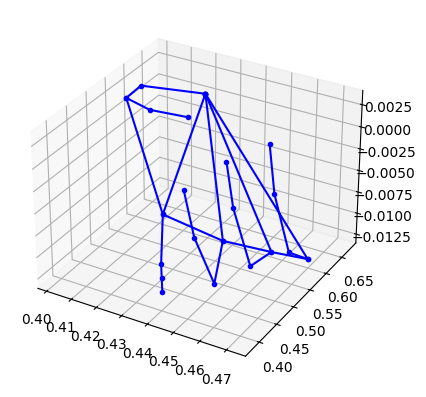

In [99]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
limb_connections = {
    "thumb": np.array([0, 1, 2, 3, 4]),
    "index": np.array([0, 5, 6, 7, 8]),
    "middle": np.array([0, 9, 10, 11, 12]),
    "ring": np.array([0, 13, 14, 15, 16]),
    "pinky": np.array([0, 17, 18, 19, 20]),
    "palm": np.array([2, 5, 9, 13, 17]),
    # "sequential": np.arange(0, 21),
}
time = 20
for limb in limb_connections.values():
    ax.plot(one_base[limb, 0, time], one_base[limb, 1, time], one_base[limb, 2, time], color='blue', marker='.')
    
# ax.plot(one_base[:,0,0], one_base[:,1,0], one_base[:,2,0], color='red', marker='.')

Show the base gesture video

/tmp/ipykernel_207782/4282412575.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


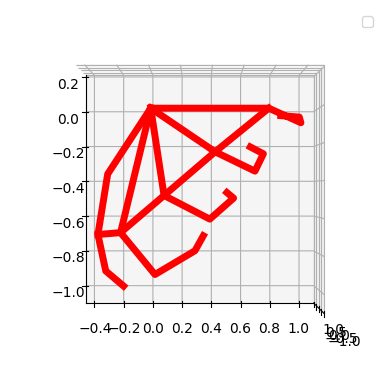

In [100]:
def video_of_hand(data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.view_init(-90, 0, 0)
    xdata, ydata, zdata = [], [], []
    (ln1,) = ax.plot([], [], [], "r", lw=5)
    (ln2,) = ax.plot([], [], [], "r", lw=5)
    (ln3,) = ax.plot([], [], [], "r", lw=5)
    (ln4,) = ax.plot([], [], [], "r", lw=5)
    (ln5,) = ax.plot([], [], [], "r", lw=5)
    (ln6,) = ax.plot([], [], [], "r", lw=5)
    (ln_ref1,) = ax.plot([], [], [], "b", lw=5)
    (ln_ref2,) = ax.plot([], [], [], "b", lw=5)
    (ln_ref3,) = ax.plot([], [], [], "b", lw=5)
    (ln_ref4,) = ax.plot([], [], [], "b", lw=5)
    (ln_ref5,) = ax.plot([], [], [], "b", lw=5)
    (ln_ref6,) = ax.plot([], [], [], "b", lw=5)
    L = plt.legend(loc=1)  # Define legend objects


    def init():
        ax.set_xlim(data[:,0,:].min()-.1, data[:,0,:].max()+.1)
        ax.set_ylim(data[:,1,:].min()-.1, data[:,1,:].max()+.1)
        ax.set_zlim(data[:,2,:].min()-.1, data[:,2,:].max()+.1)
        return (
            ln1,
            ln2,
            ln3,
            ln4,
            ln5,
            ln6,
            ln_ref1,
            ln_ref2,
            ln_ref3,
            ln_ref4,
            ln_ref5,
            ln_ref6,
        )


    def update(i):
        # get the data of each limb
        ln1_data = data[limb_connections["thumb"], :-1, i]
        ln2_data = data[limb_connections["index"], :-1, i]
        ln3_data = data[limb_connections["middle"], :-1, i]
        ln4_data = data[limb_connections["ring"], :-1, i]
        ln5_data = data[limb_connections["pinky"], :-1, i]
        ln6_data = data[limb_connections["palm"], :-1, i]
        # # get the ref data of each limb
        # ln_ref1_data = static_base_points_in_hand_frame[limb_connections["thumb"], :]
        # ln_ref2_data = static_base_points_in_hand_frame[limb_connections["index"], :]
        # ln_ref3_data = static_base_points_in_hand_frame[limb_connections["middle"], :]
        # ln_ref4_data = static_base_points_in_hand_frame[limb_connections["ring"], :]
        # ln_ref5_data = static_base_points_in_hand_frame[limb_connections["pinky"], :]
        # ln_ref6_data = static_base_points_in_hand_frame[limb_connections["palm"], :]
        # Update the data of each limb
        ln1.set_data(ln1_data[:, 0], ln1_data[:, 1])
        ln1.set_3d_properties(ln1_data[:, 2])
        ln2.set_data(ln2_data[:, 0], ln2_data[:, 1])
        ln2.set_3d_properties(ln2_data[:, 2])
        ln3.set_data(ln3_data[:, 0], ln3_data[:, 1])
        ln3.set_3d_properties(ln3_data[:, 2])
        ln4.set_data(ln4_data[:, 0], ln4_data[:, 1])
        ln4.set_3d_properties(ln4_data[:, 2])
        ln5.set_data(ln5_data[:, 0], ln5_data[:, 1])
        ln5.set_3d_properties(ln5_data[:, 2])
        ln6.set_data(ln6_data[:, 0], ln6_data[:, 1])
        ln6.set_3d_properties(ln6_data[:, 2])
        # # Update the ref data of each limb
        # ln_ref1.set_data(ln_ref1_data[:, 0], ln_ref1_data[:, 1])
        # ln_ref1.set_3d_properties(ln_ref1_data[:, 2])
        # ln_ref2.set_data(ln_ref2_data[:, 0], ln_ref2_data[:, 1])
        # ln_ref2.set_3d_properties(ln_ref2_data[:, 2])
        # ln_ref3.set_data(ln_ref3_data[:, 0], ln_ref3_data[:, 1])
        # ln_ref3.set_3d_properties(ln_ref3_data[:, 2])
        # ln_ref4.set_data(ln_ref4_data[:, 0], ln_ref4_data[:, 1])
        # ln_ref4.set_3d_properties(ln_ref4_data[:, 2])
        # ln_ref5.set_data(ln_ref5_data[:, 0], ln_ref5_data[:, 1])
        # ln_ref5.set_3d_properties(ln_ref5_data[:, 2])
        # ln_ref6.set_data(ln_ref6_data[:, 0], ln_ref6_data[:, 1])
        # ln_ref6.set_3d_properties(ln_ref6_data[:, 2])

        return (
            ln1,
            ln2,
            ln3,
            ln4,
            ln5,
            ln6,
            ln_ref1,
            ln_ref2,
            ln_ref3,
            ln_ref4,
            ln_ref5,
            ln_ref6,
        )


    ani = FuncAnimation(fig, update, frames=list(range(data.shape[2])), init_func=init, blit=True, interval=100)

    return HTML(ani.to_html5_video())

for i in range(one_base.shape[2]):
    one_base[:, :-1, i] = to_hand_frame(one_base[:, :-1, i])
video_of_hand(one_base)

Now Let's load and compare with another one signal, this time from yt

In [101]:
def get_data_in_time(one_data_test, tb, time):
    one_data_test['time'] = pd.to_datetime(one_data_test['time'], format='%H:%M:%S.%f')
    one_data_test['time'] = one_data_test['time'] - one_data_test['time'][0]
    one_data_test['time'] = one_data_test['time'].dt.total_seconds()
    # Filter to get only the data of the one signal
    one_data_test = one_data_test[one_data_test['time'] >= time[0]]
    one_data_test = one_data_test[one_data_test['time'] <= time[1]]
    # And transform it to the same shape as the one_base
    one_test_ni = []
    for index in range(21):
        index_data = one_data_test[one_data_test['index'] == index]
        index_data = index_data.sort_values(by='time')
        one_test_ni.append([index_data['x'].values, index_data['y'].values, index_data['z'].values, index_data['time'].values])
    one_test_ni = np.array(one_test_ni)
    # index finger, [x, y, z, time], time
    one_test_ni[0, 0, :] # all data for index zero, x coordinate
    # tb = one_base[0, -1, :]
    one_test = []
    for index in range(21):
        t_uns = one_test_ni[index, -1, :]
        _, xb = interpolate_match(tb, t_uns, one_test_ni[index, 0, :])
        _, yb = interpolate_match(tb, t_uns, one_test_ni[index, 1, :])
        t_t, zb = interpolate_match(tb, t_uns, one_test_ni[index, 2, :])
        one_test.append(np.stack((xb, yb, zb, t_t), axis=0))
    one_test = np.array(one_test)
    return one_test

In [102]:
one_data_test = pd.read_csv(
    "./gesture_data/ONE_YT_2_Transcription_Right_Hand.csv",
    parse_dates=True,
)


And generate the video to compare

/tmp/ipykernel_207782/4282412575.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


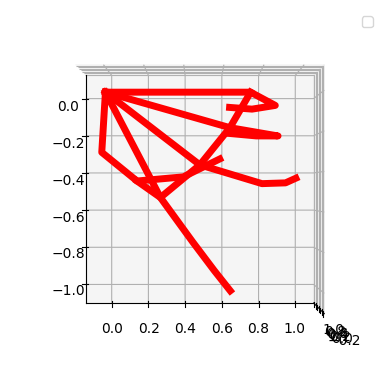

In [103]:
one_test = get_data_in_time(one_data_test, one_base[0, -1, :], [4, 6.5])
# Rotate data 
for i in range(one_test.shape[2]):
    one_test[:, :-1, i] = to_hand_frame(one_test[:, :-1, i])
video_of_hand(one_test)

And now the function that compares the two movements using the cross-correlation

In [104]:
def compare_cross_corr(base_data, incoming_data):
    """
    Compare the cross correlation between the base data and the incoming data.

    Parameters
    ----------
    base_data : np.ndarray
        Base data.
    incoming_data : np.ndarray
        Incoming data.

    Returns
    -------
    np.ndarray
        Mean INCC between the base data and the incoming data.
    """
    mean_incc = 0
    for i in range(base_data.shape[0]):
        for j in range(base_data.shape[1] - 1):
            mean_incc += incc(base_data[i, j, :], incoming_data[i, j, :])
    return mean_incc / (base_data.shape[0] * (base_data.shape[1] - 1))

And the mean INNC are

In [105]:
print(f'Mean INCC = {compare_cross_corr(one_base, one_test)}')
print(f'Sanity check. Mean INCC = {compare_cross_corr(one_base, one_base)}')

Mean INCC = 0.5131429075387496
Sanity check. Mean INCC = 0.9523809523809523


Now let's compare the one_base movement gesture with the two movement gesture to see what happens.

/tmp/ipykernel_207782/4282412575.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


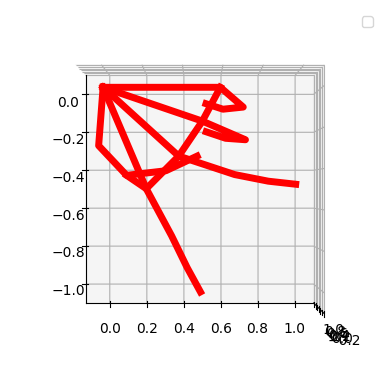

In [108]:
one_data_test = pd.read_csv(
    "./gesture_data/ONE_YT_2_Transcription_Right_Hand.csv",
    parse_dates=True,
)
two_test = get_data_in_time(one_data_test, one_base[0, -1, :], [6.5, 7.8])
# Rotate data
for i in range(two_test.shape[2]):
    two_test[:, :-1, i] = to_hand_frame(two_test[:, :-1, i])
video_of_hand(two_test)

The INCC between the base one and the two is

In [109]:
print(f'Mean INCC = {compare_cross_corr(one_base, two_test)}')

Mean INCC = 0.724097854054582
